<a href="https://colab.research.google.com/github/pranathibinf/CHANGE_Seq_analysis/blob/main/Change_seq_LRRK2_off_target_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fetching the files and visualizing them
import os
import pyBigWig
import numpy as np
import matplotlib.pyplot as plt

# Step 1 — Path to extracted BigWig files
path = '/content/projects/CHANGEseq/'
bw_files = os.listdir(path)

# Step 2 — Define histone marks to plot
marks_to_plot = {
    'H3K4me1': None,
    'H3K4me3': None,
    'H3K9me3': None,
    'H3K9ac': None,
    'H3K27me3': None,
    'H3K27ac': None,
    'H3K36me3': None
}

# Step 3 — Assign correct files to each mark
for f in bw_files:
    for mark in marks_to_plot.keys():
        if mark in f:
            marks_to_plot[mark] = os.path.join(path, f)

print("Marks found:", marks_to_plot)

# Step 4 — Define LRRK2 region
chromosome = 'chr12'
start = 40567000
end = 40653000

# Step 5 — Fetch signals for each mark
signals = {}

for mark, filepath in marks_to_plot.items():
    if filepath:
        bw = pyBigWig.open(filepath)
        signal = bw.values(chromosome, start, end, numpy=True)
        signal = np.nan_to_num(signal)
        signals[mark] = signal
        bw.close()

# Step 6 — Plot all marks together
plt.figure(figsize=(14,7))

for mark, signal in signals.items():
    plt.plot(np.arange(start, end), signal, label=mark, lw=0.8)

plt.title('Histone Modification Signals over LRRK2 (chr12:{}-{})'.format(start, end))
plt.xlabel('Genomic Position')
plt.ylabel('Signal Intensity')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# All files processing, signals recorded in single file. Visualizations.
import pyBigWig
import numpy as np
import pandas as pd
import os

# Set paths
BW_DIR = '/content/projects/CHANGEseq/raw_data/'
OUTPUT_DIR = '/content/projects/CHANGEseq/output/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Signal threshold to define peaks
threshold = 5

# List all BigWig files
bw_files = [f for f in os.listdir(BW_DIR) if f.endswith('.bw')]

for bw_file in bw_files:
    full_path = os.path.join(BW_DIR, bw_file)
    print(f"Processing {bw_file}")

    # Open BigWig
    bw = pyBigWig.open(full_path)

    # Get chromosomes
    chromosomes = bw.chroms().keys()

    peaks = []

    # Scan all chromosomes
    for chrom in chromosomes:
        chrom_len = bw.chroms()[chrom]
        signal = bw.values(chrom, 0, chrom_len, numpy=True)
        signal = np.nan_to_num(signal)

        in_peak = False
        peak_start = 0
        peak_signal = []

        for i, val in enumerate(signal):
            if val >= threshold:
                if not in_peak:
                    peak_start = i
                    peak_signal = []
                    in_peak = True
                peak_signal.append(val)
            else:
                if in_peak:
                    peak_end = i
                    max_signal = np.max(peak_signal)
                    peaks.append([chrom, peak_start, peak_end, max_signal])
                    in_peak = False

    # Save peaks to CSV
    df_peaks = pd.DataFrame(peaks, columns=['Chromosome', 'Start', 'End', 'MaxSignal'])
    csv_name = bw_file.replace('.bw', '_offtarget_peaks.csv')
    df_peaks.to_csv(os.path.join(OUTPUT_DIR, csv_name), index=False)

    # Close BigWig
    bw.close()

print("Finished processing all BigWig files!")


Processing GSM4495703_H3K4me3_FE.bdg.bw
Processing GSM4495701_H3K4me1_FE.bdg.bw
Processing GSM4495705_H3K9me3_FE.bdg.bw
Processing GSM4495713_H3K36me3_FE.bdg.bw
Processing GSM4495707_H3K9ac_FE.bdg.bw
Processing GSM4495709_H3K27me3_FE.bdg.bw
Processing GSM4495711_H3K27ac_FE.bdg.bw
Finished processing all BigWig files!


In [5]:
import pandas as pd
import os

# Set output folder
OUTPUT_DIR = '/content/projects/CHANGEseq/output/'

# List all peak CSV files
csv_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('_offtarget_peaks.csv')]

# Store all dataframes
dfs = []

for csv_file in csv_files:
    df = pd.read_csv(os.path.join(OUTPUT_DIR, csv_file))
    df['HistoneMark'] = csv_file.split('_')[1]
    dfs.append(df)

# Concatenate all
master_df = pd.concat(dfs, ignore_index=True)

# Save master CSV
master_csv_path = os.path.join(OUTPUT_DIR, 'all_offtarget_peaks_combined.csv')
master_df.to_csv(master_csv_path, index=False)

print(f"Master file created: {master_csv_path}")


✅ Master file created: /content/projects/CHANGEseq/output/all_offtarget_peaks_combined.csv


In [6]:
# Task 1 — Analyze LRRK2 region specifically
import pandas as pd
import os

# Set output folder
OUTPUT_DIR = '/content/projects/CHANGEseq/output/'

# Read the combined master CSV
master_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'all_offtarget_peaks_combined.csv'))

# define LRRK2 region
lrrk2_chr = 'chr12'
lrrk2_start = 40567000
lrrk2_end = 40653000

# filter for peaks inside LRRK2
lrrk2_peaks = master_df[
    (master_df['Chromosome'] == lrrk2_chr) &
    (master_df['Start'] >= lrrk2_start) &
    (master_df['End'] <= lrrk2_end)
]

# Save LRRK2 specific peaks
lrrk2_peaks.to_csv(os.path.join(OUTPUT_DIR, 'LRRK2_specific_peaks.csv'), index=False)

print(f"✅ Found {len(lrrk2_peaks)} peaks inside LRRK2 region.")

✅ Found 29 peaks inside LRRK2 region.


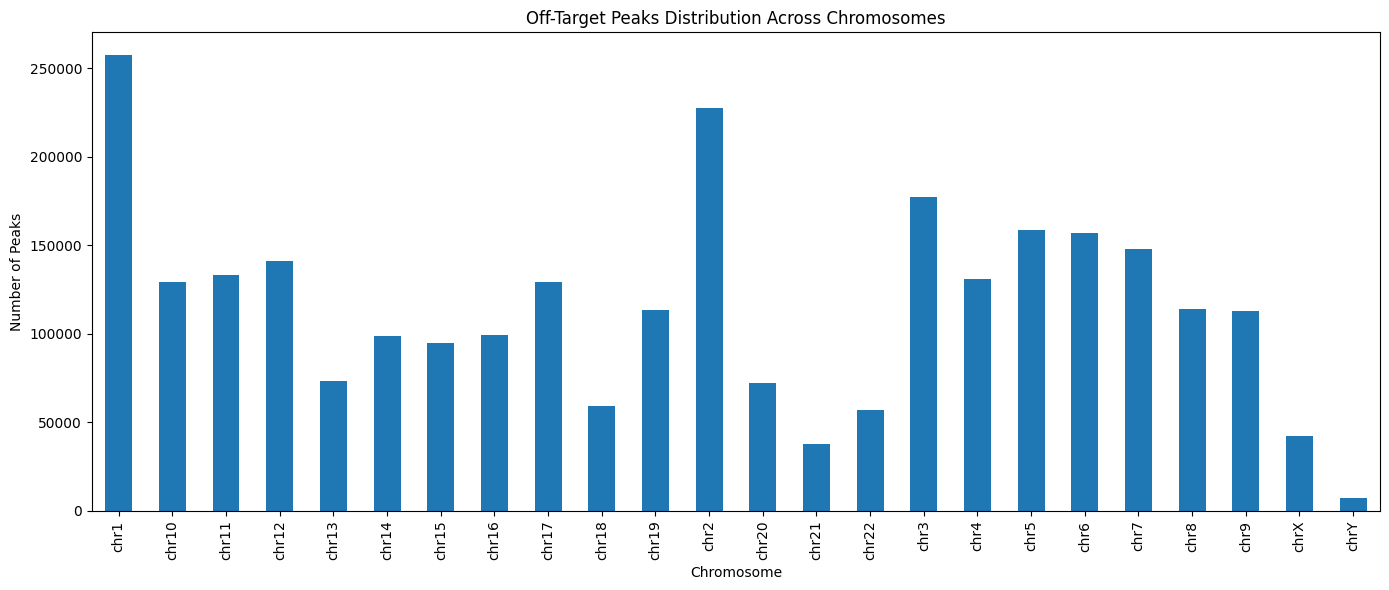

In [7]:
# Task 2 — Visualize off-target peaks across genome
import matplotlib.pyplot as plt

# Count number of peaks per chromosome
chrom_counts = master_df['Chromosome'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14,6))
chrom_counts.plot(kind='bar')
plt.title('Off-Target Peaks Distribution Across Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Number of Peaks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Task 3 — Rank off-target peaks by signal strength
# sort by max-signal descending
top_peaks = master_df.sort_values(by='MaxSignal', ascending=False)

# Save top 50 peaks
top_peaks.head(50).to_csv(os.path.join(OUTPUT_DIR, 'Top50_offtarget_peaks.csv'), index=False)

print(f"✅ Saved Top 50 strongest off-target peaks.")

✅ Saved Top 50 strongest off-target peaks.
